### Load pretrained classifier model

In [2]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import numpy as np

base_model = VGG16(weights="imagenet")


plot_model(base_model, to_file="vgg16.png", show_shapes=True, show_layer_names=True)

print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

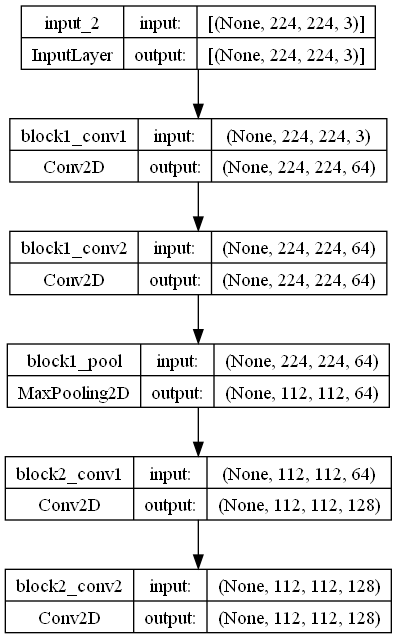

In [7]:
import keras


l = base_model.layers[5].output

m = keras.Model(inputs=base_model.input, outputs=l)


plot_model(m, to_file="sub.png", show_shapes=True, show_layer_names=True)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


# img_path = 'images/elephant.jpeg'
img_path = 'images/highway.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = base_model.predict(x)

decoded = decode_predictions(preds, top=5)[0]

print('Predicted:')
for i, p in enumerate(decoded):
    print(f" {i+1}: p = {p[2]:.4f}, class = \"{p[1]}\"")


### Show the activations of each layer of the model

Note: for layers with a "depth" greater than 3, we take the norm along the channel axis to get a single value for each pixel.

Each layer is run individually using the previous layer's output, and the new output is kept for the next iteration.
This is done instead of just re-running the model with more and more layers each time.

In [ ]:
# start with the input image
activations = [x]

# for each layer, get the output from the previous layer and append it to the list of outputs
for layer in base_model.layers:
    activations.append(layer(activations[-1]))

In [ ]:
import numpy.linalg as la

inner_layer_norms = []

for i, output in enumerate(activations):
    print(layer.name, output.shape)

    # if the output is at least 4D (batch_size, x, y, channels), plot the output as an image
    if len(output.shape) == 4:

        # if the output has 3 channels, assume it's an image with RGB channels
        if output.shape[3] == 3:

            # plot the image
            # note: vgg16 converts the image to BGR format, and centers the values around 0, 
            # so we have to reverse the channel order "::-1" and shift everything by 0.5 to get positive values (some still get clipped but it works well enough)
            plt.imshow(output[0, :, :, ::-1]/255 + 0.5)
        else:
            # calculate pixel intensity as the norm along the channels axis
            plt.imshow(la.norm(output[0, :, :, :], axis=2))

        plt.show()
    else:
        # not an image, so plot as a graph
        plt.plot(output[0])
        plt.show()


decoded = decode_predictions(np.array(output), top=5)[0]

print('Predicted:')
for i, p in enumerate(decoded):
    print(f" {i+1}: p = {p[2]:.4f}, id = {p[0]}, class = \"{p[1]}\"")
    

## Crudely apply an attention heatmap to the original image

In [ ]:
resized_outputs = []

# skip first layer as it's the input image
for i, output in enumerate(outputs[1:]):

    if len(output.shape) != 4:
        # we've reached the fully connected layers, so we're done
        break

    # upscale the output to 224x224
    resized = tf.image.resize(output, (224, 224))

    # average the channels (usually there are 64) to get a grayscale heatmap
    # resized = np.average(resized[0, :, :, :], axis=2)
    resized = la.norm(resized[0, :, :, :], axis=2)

    # convert from (224, 224) to (224, 224, 3) so we can overlay it on the original RGB image 
    # (here we just use the red channel and set the rest to 0)
    resized = np.stack((resized, resized, resized), axis=2)

    # scale the values to be between 0 and 1
    min_val = np.min(resized)
    max_val = np.max(resized)

    # scale the values
    resized = (resized - min_val) / (max_val - min_val)

    resized_outputs.append(resized)
        

# plot the original image
scaled_img = np.array(img) / 255
plt.imshow(scaled_img)
plt.show()

# same size as the original image
heatmap = np.zeros((224, 224, 3))

# apply each heatmap to the image and plot the result
for resized in resized_outputs:

    heatmap += resized

    # scale the values to be between 0 and 1
    min_val = np.min(heatmap)
    max_val = np.max(heatmap)

    # scale the values
    scaled_heatmap = (heatmap - min_val) / (max_val - min_val)

    # plot the the image with the heatmap next to the layer output
    plt.subplot(121)
    plt.imshow(scaled_heatmap)
    plt.subplot(122)
    plt.imshow(resized)

    plt.show()
    

scaled_heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# apply the heatmap to the original image
img_with_heatmap = scaled_img * scaled_heatmap

# scale the values to be between 0 and 1
min_val = np.min(img_with_heatmap)
max_val = np.max(img_with_heatmap)

# scale the values
scaled_img_with_heatmap = (img_with_heatmap - min_val) / (max_val - min_val)

# plot the the image with the heatmap next to the layer output

print("Image with heatmap next to original image")
plt.subplot(121)
plt.imshow(scaled_img_with_heatmap)
plt.subplot(122)
plt.imshow(scaled_img)

plt.show()

